# **Time Series ML with LSTM with Keras (TF 2.0)**

This notebook is for me practicing time series ML with LSTM and based on **Multivariate Time Series Forecasting with LSTMs in Keras** by **Jason Brownlee** . The brilliant original work is here https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


The raw data file is a Beijing air quality dataset. the dataset was pre-processed a bit to be used in this work.

In the input dataset, 13 features present. a many-to-one LSTM model is used with multiple timesteps and features input, one timestep and selected features ouput.



## modification from the original work

1.   One-hot encoding is implemented for 'wind direction'.
2.   'hours' and 'day-of-year' features are added.
3.   Providing more than 1 hour of input time steps.https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
4.   make output features selectable, automatically drop others


## conditions


*   input timesteps = 24 hours
*   pred timestep = 1 hour
*   input features: all
*   output features: pm2.5, temp, rain, hour
*   train data duration: 4 years
*   test data duration: 1 year
*   neurons = 50
*   stateful = false  due to relatively small number of timesteps (N < 1000)
*   return_sequence = false  for 1 timestep output






























In [0]:
!pip install --upgrade -q tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pydot
import os

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

import tensorflow as tf
print(tf.__version__)


#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.callbacks import LearningRateScheduler

2.0.0


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')




## **Processing data**


In [0]:
# load dataset

gdrive="/content/gdrive/My Drive/Colab Notebooks/time series/data/"

dataset = pd.read_csv(gdrive + 'beijing_pm25_dp.csv', header=0, index_col=0)
values = dataset.values


In [4]:
dataset.head()

,pm2.5,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv,doy,hour
date,,,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0,2,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0,2,1
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0,2,2
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0,2,3
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0,2,4


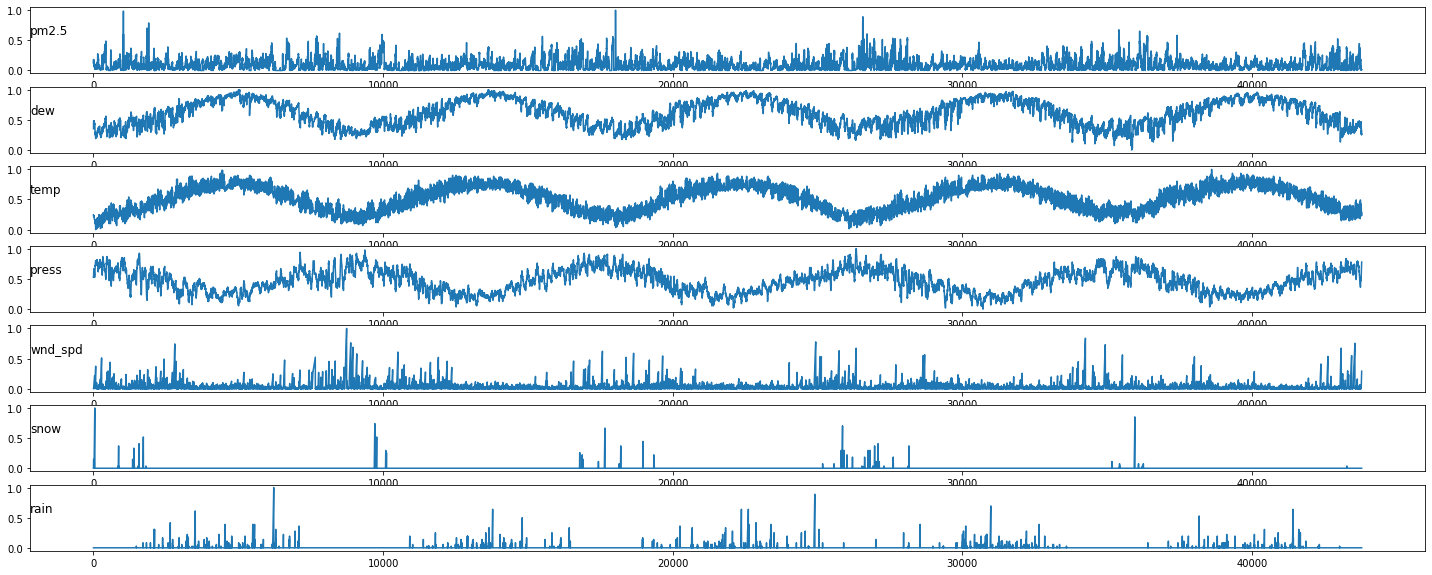

In [138]:
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure(figsize=(25,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='left')
	i += 1
plt.show()

In [0]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [0]:
# convert series to supervised learning

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [0]:
def drop_out_col(n_in, n_out, n_in_features, out_keep):
  columns=np.arange(n_in_features)
  columns=np.setdiff1d(columns, out_keep)

  drop = np.array([])
  for i in range(n_out):
    drop = np.append(drop, n_in_features*i+columns)
  
  drop+= n_in*n_in_features

  return np.int_(drop)


def name_to_col(dataset, name):
  return np.sort([dataset.columns.get_loc(c) for c in name if c in dataset])

In [139]:
# convert data to supervised learning format to feed LSTM 
# example: 
# input = 3 step, output = 1 time step, 3 features, pm2.5, rain, snow [0,5,6]
# each series has 13 features, input data has 3*13=39 column. output has 3, which are 39+[0,5,6]=[39,44,45]
# columns to drop from the output of series_to_supervised are [40,41,42,43,46,47,48,49,50,51]



# specify the number of lag hours
n_in =24                          ################################################test

# output time step
n_out = 1                               ############################################test

# input features
n_in_features = dataset.shape[1]

# output features
out_features = ['pm2.5', 'rain', 'temp', 'hour']  ##################################test


n_out_features = len(out_features)
keep_col = name_to_col(dataset, out_features)

out_features = dataset.columns[keep_col]

drop_col= drop_out_col(n_in, n_out, n_in_features, keep_col)

print(n_in_features, n_out_features)
print(out_features,keep_col,drop_col)

reframed = series_to_supervised(scaled, n_in, n_out)
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)
print(reframed.shape)

13 4
Index(['pm2.5', 'temp', 'rain', 'hour'], dtype='object') [ 0  2  6 12] [313 315 316 317 319 320 321 322 323]
(43776, 316)


In [140]:
reframed.head()

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var10(t-24),var11(t-24),var12(t-24),var13(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),var5(t-23),var6(t-23),var7(t-23),var8(t-23),var9(t-23),var10(t-23),var11(t-23),var12(t-23),var13(t-23),var1(t-22),var2(t-22),var3(t-22),var4(t-22),var5(t-22),var6(t-22),var7(t-22),var8(t-22),var9(t-22),var10(t-22),var11(t-22),var12(t-22),var13(t-22),var1(t-21),...,var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var1(t),var3(t),var7(t),var13(t)
24,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.000000,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.043478,0.159960,0.426471,0.229508,0.545454,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.086957,0.182093,...,0.654547,0.083261,0.037037,0.0,0.0,0.0,1.0,0.0,0.002740,0.913043,0.156942,0.470588,0.213115,0.672728,0.088610,0.074074,0.0,0.0,0.0,1.0,0.0,0.002740,0.956522,0.126761,0.470588,0.213115,0.654547,0.093959,0.111111,0.0,0.0,0.0,1.0,0.0,0.002740,1.000000,0.090543,0.213115,0.0,0.000000
25,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.043478,0.159960,0.426471,0.229508,0.545454,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.086957,0.182093,0.485294,0.229508,0.563637,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0,0.00274,0.130435,0.138833,...,0.672728,0.088610,0.074074,0.0,0.0,0.0,1.0,0.0,0.002740,0.956522,0.126761,0.470588,0.213115,0.654547,0.093959,0.111111,0.0,0.0,0.0,1.0,0.0,0.002740,1.000000,0.090543,0.485294,0.213115,0.654547,0.099308,0.148148,0.0,0.0,0.0,1.0,0.0,0.005479,0.000000,0.063380,0.213115,0.0,0.043478
26,0.159960,0.426471,0.229508,0.545454,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.086957,0.182093,0.485294,0.229508,0.563637,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0,0.00274,0.130435,0.138833,0.485294,0.229508,0.563637,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0,0.00274,0.173913,0.109658,...,0.654547,0.093959,0.111111,0.0,0.0,0.0,1.0,0.0,0.002740,1.000000,0.090543,0.485294,0.213115,0.654547,0.099308,0.148148,0.0,0.0,0.0,1.0,0.0,0.005479,0.000000,0.063380,0.470588,0.213115,0.636364,0.104657,0.185185,0.0,0.0,0.0,1.0,0.0,0.005479,0.043478,0.065392,0.196721,0.0,0.086957
27,0.182093,0.485294,0.229508,0.563637,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0,0.00274,0.130435,0.138833,0.485294,0.229508,0.563637,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0,0.00274,0.173913,0.109658,0.485294,0.213115,0.563637,0.011433,0.111111,0.0,0.0,0.0,1.0,0.0,0.00274,0.217391,0.105634,...,0.654547,0.099308,0.148148,0.0,0.0,0.0,1.0,0.0,0.005479,0.000000,0.063380,0.470588,0.213115,0.636364,0.104657,0.185185,0.0,0.0,0.0,1.0,0.0,0.005479,0.043478,0.065392,0.470588,0.196721,0.636364,0.111527,0.222222,0.0,0.0,0.0,1.0,0.0,0.005479,0.086957,0.055332,0.196721,0.0,0.130435
28,0.138833,0.485294,0.229508,0.563637,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0,0.00274,0.173913,0.109658,0.485294,0.213115,0.563637,0.011433,0.111111,0.0,0.0,0.0,1.0,0.0,0.00274,0.217391,0.105634,0.485294,0.213115,0.581818,0.014492,0.148148,0.0,0.0,0.0,1.0,0.0,0.00274,0.260870,0.124748,...,0.636364,0.104657,0.185185,0.0,0.0,0.0,1.0,0.0,0.005479,0.043478,0.065392,0.470588,0.196721,0.636364,0.111527,0.222222,0.0,0.0,0.0,1.0,0.0,0.005479,0.086957,0.055332,0.470588,0.196721,0.618183,0.116876,0.259259,0.0,0.0,0.0,1.0,0.0,0.005479,0.130435,0.065392,0.196721,0.0,0.173913


In [141]:
# split into train and test sets

values = reframed.values
n_train_hours = 365 * 24 * 4   ############################################## test


train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


# split into input and outputs
n_obs = n_in * n_in_features
train_X, train_y = train[:, :n_obs], train[:, -n_out_features:]
test_X, test_y = test[:, :n_obs], test[:, -n_out_features:]
print(train_X.shape, len(train_X), train_y.shape)


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_in_features))
test_X = test_X.reshape((test_X.shape[0], n_in, n_in_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 312) 35040 (35040, 4)
(35040, 24, 13) (35040, 4) (8736, 24, 13) (8736, 4)


## **LSTM model**


In [142]:
neurons=50 #########################################################test with grid search
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])),
    tf.keras.layers.Dense(units=n_out_features)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=["accuracy"])

print(model.summary())

#tf.keras.utils.plot_model(model, to_file='digit-cnn-keras_graph.png')

#display(Image.open('digit-cnn-keras_graph.png'))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50)                12800     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 204       
Total params: 13,004
Trainable params: 13,004
Non-trainable params: 0
_________________________________________________________________
None


## **Train model**


Train on 35040 samples, validate on 8736 samples
Epoch 1/50
35040/35040 - 13s - loss: 0.0105 - accuracy: 0.8465 - val_loss: 0.0153 - val_accuracy: 0.8036
Epoch 2/50
35040/35040 - 10s - loss: 0.0017 - accuracy: 0.9434 - val_loss: 0.0060 - val_accuracy: 0.8527
Epoch 3/50
35040/35040 - 10s - loss: 0.0011 - accuracy: 0.9554 - val_loss: 0.0032 - val_accuracy: 0.8866
Epoch 4/50
35040/35040 - 10s - loss: 8.8564e-04 - accuracy: 0.9619 - val_loss: 0.0020 - val_accuracy: 0.9052
Epoch 5/50
35040/35040 - 10s - loss: 7.8487e-04 - accuracy: 0.9636 - val_loss: 0.0017 - val_accuracy: 0.9122
Epoch 6/50
35040/35040 - 10s - loss: 6.9994e-04 - accuracy: 0.9665 - val_loss: 0.0014 - val_accuracy: 0.9182
Epoch 7/50
35040/35040 - 10s - loss: 6.3349e-04 - accuracy: 0.9687 - val_loss: 0.0012 - val_accuracy: 0.9249
Epoch 8/50
35040/35040 - 10s - loss: 5.7916e-04 - accuracy: 0.9704 - val_loss: 9.7008e-04 - val_accuracy: 0.9373
Epoch 9/50
35040/35040 - 10s - loss: 5.3558e-04 - accuracy: 0.9719 - val_loss: 8.1876e-

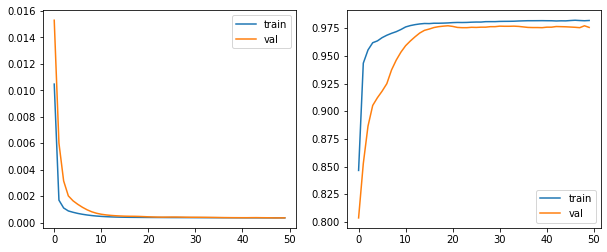

In [143]:

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show() 

## **Prediction**

In [0]:
# make a prediction
yhat = model.predict(test_X)


In [0]:
test_X_r = test_X.reshape((test_X.shape[0], n_in*n_in_features))

# invert scaling for forecast
inv_yhat = test_X_r[:, -n_in_features:]

for i,keep in zip(np.arange(yhat.shape[-1]), keep_col) :
  inv_yhat[:,keep]=yhat[:,i] 

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,keep_col]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), n_out_features))
inv_y = test_X_r[:, -n_in_features:]

for i,keep in zip(np.arange(test_y.shape[-1]), keep_col) :
  inv_y[:,keep]=test_y[:,i] 

inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,keep_col]



In [146]:
# calculate RMSE
for i in range(n_out_features):
  rmse = np.sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
  mean = np.mean(inv_y[:,i])
  print('Test of %s: mean=%.2f, rmse=%.2f' % (out_features[i],mean, rmse))

Test of pm2.5: mean=96.75, rmse=24.52
Test of temp: mean=13.70, rmse=1.42
Test of rain: mean=0.14, rmse=0.53
Test of hour: mean=11.50, rmse=0.21


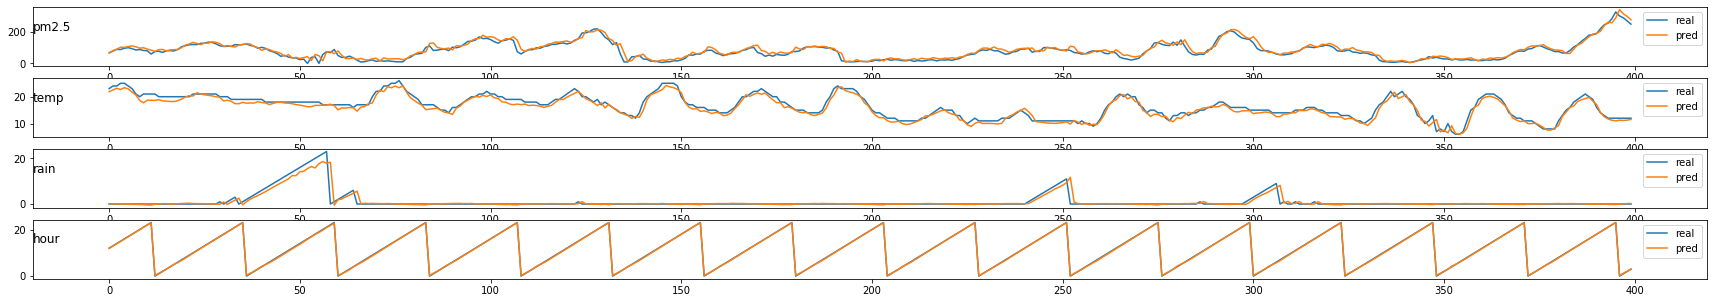

In [147]:
plt.figure(figsize=(30,5))

for i in range(n_out_features) :
  plt.subplot(n_out_features ,1,i+1)
  plt.plot(inv_y[6300:6700,i], label='real')
  plt.plot(inv_yhat[6300:6700,i], label='pred')
  plt.legend()
  plt.title(out_features[i], y=0.5, loc='left')

plt.show() 

## Output

In [0]:
#output.to_csv('time-series-bjpm25-lstm-t1.csv', index = False)


In [0]:
#model.save("time-series-bjpm25-lstm-t1.h5")

## **Next steps**



*   Making all series stationary with differencing and seasonal adjustment. https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
*   tune number of neurons https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/
*   internal state depends on number of days





# **Credit**

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


